# start

In [2]:
import torch
import numpy as np
from Codes.Losses.snake import Snake
from Codes.Losses.gradImSnake import cmptExtGrad
from Codes.Losses.gradImSnake import cmptGradIm, makeGaussEdgeFltr
import torch.nn.functional as F
import networkx as nx
from math import sin, pi, cos
from matplotlib.path import Path
import matplotlib.pyplot as plt
from functools import reduce
import math

In [50]:
class RibbonSnake(Snake):
    def __init__(self, graph, crop, stepsz, alpha, beta, dim):
        # In the new version grad will be separate, so image gradients will not be here
        # Normal initialization of Snake super class
        super().__init__(graph, crop, stepsz, alpha, beta, dim)
        # Additionally we sample from a normal distrubution for widths of nodes
        self.w = torch.randn(self.s.shape[0], requires_grad=False).abs()

    def cuda(self):
        super().cuda()
        # move the widths to gpu
        self.w = self.w.cuda()

    def set_w(self, widths):
        self.w = widths

    def get_w(self):
        return self.w

    def _compute_normals(self, pos):
        """
        Compute normals (and tangents for 3D) for each center point.
        Returns:
         - 2D: (normals,) where normals is (N,2)
         - 3D: (n1, n2, tangents) each (N,3)
        """
        N, d = pos.shape
        eps = 1e-8
        # Compute tangents by central differences
        t = torch.zeros_like(pos)
        if N > 1:
            t[1:-1] = (pos[2:] - pos[:-2]) * 0.5
            t[0] = pos[1] - pos[0]
            t[-1] = pos[-1] - pos[-2]
        # Normalize tangents
        t = t / (t.norm(dim=1, keepdim=True) + eps)

        if self.ndims == 2:
            # Perpendicular in 2D: (-y, x)
            normals = torch.stack([-t[:,1], t[:,0]], dim=1)
            normals = normals / (normals.norm(dim=1, keepdim=True) + eps)
            return (normals,)
        else:
            # Choose arbitrary axis (1,0,0), but avoid colinearity
            a = torch.zeros_like(pos)
            a[:] = torch.tensor([1.0, 0.0, 0.0], device=pos.device)
            mask = (t * a).abs().sum(dim=1) > 0.9
            a[mask] = torch.tensor([0.0, 1.0, 0.0], device=pos.device)
            # First normal via cross
            n1 = torch.cross(t, a, dim=1)
            n1 = n1 / (n1.norm(dim=1, keepdim=True) + eps)
            # Second normal orthogonal to both
            n2 = torch.cross(t, n1, dim=1)
            n2 = n2 / (n2.norm(dim=1, keepdim=True) + eps)
            return (n1, n2, t)
        
    def comp_second_deriv(self):
        """
        1D second-derivative smoothing for widths via convolution.
        """
        w = self.w.view(1, 1, -1)
        kernel = torch.tensor([1.0, -4.0, 6.0, -4.0, 1.0], device=w.device).view(1,1,5)
        grad_norm = F.conv1d(w, kernel, padding=2)
        return grad_norm.view(-1,1)
    
    def step_widths(self, gimgW, n_samples=16):
        """
        Vectorized update of widths in 2D or 3D.

        gimgW: image-gradient tensor (2xHxW or 3xDxHxW)
        n_samples: number of radial directions to sample (default 8)
        """
        if self.s.numel() == 0:
            return self.w

        pos = self.s                  # (N, d)
        K, d = pos.shape
        device = pos.device
        half_r = self.w * 0.5 # N

        if d == 2:
            (normals,) = self._compute_normals(pos)
            left_pts  = pos - normals * half_r
            right_pts = pos + normals * half_r

            grad_L = cmptExtGrad(left_pts,  gimgW)
            grad_R = cmptExtGrad(right_pts, gimgW)
            # radial derivative
            grad_w = ((grad_R - grad_L) * normals).sum(dim=1, keepdim=True)

        else:  # d == 3
            n1, n2, _ = self._compute_normals(pos)   # each (K,3)

            N = 8
            theta = torch.linspace(0, 2*math.pi, N, device=device, dtype=pos.dtype)[:-1]  # (N-1,)
            dirs = (
                theta.cos().unsqueeze(1).unsqueeze(2) * n1.unsqueeze(0) +
                theta.sin().unsqueeze(1).unsqueeze(2) * n2.unsqueeze(0)
            )  # (N-1, K, 3)

            pts_out = pos.unsqueeze(0) + half_r.unsqueeze(0).unsqueeze(2) * dirs   # (N-1, K, 3)
            pts_in = pos.unsqueeze(0) - half_r.unsqueeze(0).unsqueeze(2) * dirs   # (N-1, K, 3)
            all_pts = torch.cat([pts_out, pts_in], dim=0) # (2(N-1), K, 3)

            grads = cmptExtGrad(all_pts.view(-1,3), gimgW)# (2(N-1)*K, 3)
            grads = grads.view(2*(N-1), -1,3)

            grad_diff = grads[:(N-1)] - grads[(N-1):] # (N-1, K, 3)
            radial = (grad_diff * dirs).sum(dim=2) # (N-1, K)
            grad_w = radial.mean(dim=0, keepdim=True).t() # (K,1)
            norm_grad = self.comp_second_deriv() # (K,1)
            w_flat    = self.w.view(-1) # (K,)
            smooth    = torch.zeros_like(w_flat) # (K,)

            if K > 1:
                smooth[0]   = w_flat[0]   - w_flat[1]
                smooth[-1]  = w_flat[-1]  - w_flat[-2]
                if K > 2:
                    smooth[1:-1] = 2*w_flat[1:-1] - w_flat[:-2] - w_flat[2:]

            smooth = smooth.view(K,1) # (K,1)
            internal = norm_grad + smooth # (K,1)
            alpha = grad_w.abs() / (internal.abs() + 1e-8)
            total = grad_w + alpha * internal # (K,1)
            self.w = self.w - self.stepsz * total.squeeze(1)
            return self.w

        # internal smoothness
        internal = self.comp_second_deriv()
        alpha = grad_w.abs() / (internal.abs() + 1e-8)
        total = (grad_w + alpha * internal).squeeze(1)
        # gradient step
        self.w = self.w - self.stepsz * total
        return self.w
    
    def render_distance_map_with_widths(self, size):
        """
        Unified 2D/3D signed distance map for the ribbon snake.

        Args:
            size (tuple): (W, H) for 2D or (X, Y, Z) for 3D grid dimensions.

        Returns:
            torch.Tensor: Signed distance map of shape `size`, where negative values indicate points inside the ribbon and positive values the distance to the nearest edge.
        """
        device = self.s.device
        centers = self.s
        radii   = (self.w.flatten() / 2)
        axes    = [torch.arange(sz, device=device, dtype=torch.float32) for sz in size]
        mesh    = torch.meshgrid(*axes, indexing='ij')
        points  = torch.stack([m.flatten() for m in mesh], dim=1)

        # capsule sides
        if centers.shape[0] > 1:
            starts, ends = centers[:-1], centers[1:]
            r0, r1 = radii[:-1], radii[1:]
            vec = ends - starts
            L   = vec.norm(dim=1, keepdim=True)
            D   = vec / (L + 1e-8)

            P = points.unsqueeze(1)
            S = starts.unsqueeze(0)
            D = D.unsqueeze(0)
            L = L.unsqueeze(0).squeeze(-1)

            v    = P - S
            proj = (v * D).sum(dim=2)
            # clamp proj to [0, L]
            low  = proj.clamp(min=0.0)
            t    = torch.min(low, L)

            closest       = S + D * t.unsqueeze(-1)
            dist_axis     = (P - closest).norm(dim=2)
            frac          = t / (L + 1e-8)
            interp_radius = r0 * (1-frac) + r1 * frac
            dist_capsule, _ = (dist_axis - interp_radius).min(dim=1)
        else:
            dist_capsule = torch.full((points.shape[0],), float('inf'), device=device)

        # end caps
        start_c = centers[0]; end_c = centers[-1]
        dist_start = (points - start_c).norm(dim=1) - radii[0]
        dist_end   = (points - end_c).norm(dim=1)   - radii[-1]

        dist = torch.min(dist_capsule, dist_start)
        dist = torch.min(dist, dist_end)
        return torch.clamp(dist.reshape(*size), max=16)

In [51]:
def makeGaussEdgeFltr(stdev,d):
    # make a Gaussian-derivative-based edge filter
    # filter size is determined automatically based on stdev
    # the filter is ready to be used with pytorch conv 
    # input params:
    #   stdev - the standard deviation of the Gaussian
    #   d - number of dimensions
    # output:
    #   fltr, a np.array of size d X 1 X k X k,
    #         where k is an odd number close to 4*stdev
    #         fltr[i] contains a filter sensitive to gradients
    #         along the i-th dimension

    fsz=round(2*stdev)*2+1 # filter size - make the it odd

    n=np.arange(0,fsz).astype(float)-(fsz-1)/2.0
    s2=stdev*stdev
    v=np.exp(-n**2/(2*s2)) # a Gaussian
    g=n/s2*v # negative Gaussian derivative

    # create filter sensitive to edges along dim0
    # by outer product of vectors
    shps = np.eye(d,dtype=int)*(fsz-1)+1
    reshaped = [x.reshape(y) for x,y in zip([g]+[v]*(d-1), shps)]
    fltr=reduce(np.multiply,reshaped)
    fltr=fltr/np.sum(np.abs(fltr))
    
    # add the out_channel, in_channel initial dimensions
    fltr_=fltr[np.newaxis,np.newaxis]
    # transpose the filter to be sensitive to edges in all directions 
    fltr_multidir=np.concatenate([np.moveaxis(fltr_,2,k) for k in range(2,2+d)],axis=0)
    
    return fltr_multidir

def cmptGradIm(img,fltr):
    # convolves img with fltr, with replication padding
    # fltr is assumed to be of odd size
    # img  is either 2D: batch X channel X height X width
    #             or 3D: batch X channel X height X width X depth
    #      it is a torch tensor
    # fltr is either 2D: 2 X 1 X k X k
    #             or 3D: 3 X 1 X k X k X k
    #      it is a torch tensor
    
    if img.dim()==4:
        img_p=torch.nn.ReplicationPad2d(fltr.shape[2]//2).forward(img)
        return torch.nn.functional.conv2d(img_p,fltr)
    if img.dim()==5:
        img_p=torch.nn.ReplicationPad3d(fltr.shape[2]//2).forward(img)
        return torch.nn.functional.conv3d(img_p,fltr)
    else:
        raise ValueError("img should have 4 or 5 dimensions")

def cmptExtGrad(snakepos,eGradIm):
    # returns the values of eGradIm at positions snakepos
    # snakepos  is a k X d matrix, where snakepos[j,:] represents a d-dimensional position of the j-th node of the snake
    # eGradIm   is a tensor containing the energy gradient image, either of size
    #           3 X d X h X w, for 3D, or of size
    #           2     X h X w, for 2D snakes
    # returns a tensor of the same size as snakepos,
    # containing the values of eGradIm at coordinates specified by snakepos
    
    # scale snake coordinates to match the hilarious requirements of grid_sample
    # we use the obsolote convention, where align_corners=True
    scale=torch.tensor(eGradIm.shape[1:]).reshape((1,-1)).type_as(snakepos)-1.0
    sp=2*snakepos/scale-1.0
    
    if eGradIm.shape[0]==3:
        # invert the coordinate order to match other hilarious specs of grid_sample
        spi=torch.einsum('km,md->kd',[sp,torch.tensor([[0,0,1],[0,1,0],[1,0,0]]).type_as(sp).to(sp.device)])
        egrad=torch.nn.functional.grid_sample(eGradIm[None],spi[None,None,None],
                                           align_corners=True)
        egrad=egrad.permute(0,2,3,4,1)
    if eGradIm.shape[0]==2:
        # invert the coordinate order to match other hilarious specs of grid_sample
        spi=torch.einsum('kl,ld->kd',[sp,torch.tensor([[0,1],[1,0]]).type_as(sp).to(sp.device)])
        egrad=torch.nn.functional.grid_sample(eGradIm[None],spi[None,None],
                                           align_corners=True)
        egrad=egrad.permute(0,2,3,1)
        
    return egrad.reshape_as(snakepos)

class GradImRib(RibbonSnake):
    def __init__(self, graph, crop, stepsz, alpha, beta, dim, gimgV, gimgW):
        super().__init__(graph, crop, stepsz, alpha, beta, dim)

        self.gimgV = gimgV
        self.gimgW = gimgW
    
    def cuda(self):
        super().cuda()
        if self.gimgV is not None:
            self.gimgV = self.gimgV.cuda()
        if self.gimgW is not None:
            self.gimgW = self.gimgW.cuda()

    def step(self):
        return super().step(cmptExtGrad(self.s, self.gimgV))
    
    def step_widths(self):
        return super().step_widths(self.gimgW)
    
    def optim(self, niter):
        if len(self.s) > 0:
            for i in range(niter):
                if i < niter / 2:
                    self.step()
                else:
                    self.step_widths()
        return self.s

# Dist map CALC

In [25]:
def show_slices(distance_map, graph):
    """Show orthogonal slices through the distance map"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    xx = np.min(distance_map, axis=0)
    yy = np.min(distance_map, axis=1)
    zz = np.min(distance_map, axis=2)
    
    im0 = axes[0].imshow(xx.T, cmap='coolwarm')
    axes[0].set_title('Slice (X)')
    fig.colorbar(im0, ax=axes[0])
    
    im1 = axes[1].imshow(yy.T, cmap='coolwarm')
    axes[1].set_title('Slice (Y)')
    fig.colorbar(im1, ax=axes[1])
    
    im2 = axes[2].imshow(zz.T, cmap='coolwarm')
    axes[2].set_title('Slice (Z)')
    fig.colorbar(im2, ax=axes[2])

    for edge in graph.edges:
        node1, node2 = edge
        x1, y1, z1 = graph.nodes[node1]['pos']
        x2, y2, z2 = graph.nodes[node2]['pos']
        
        # Axial slice (X)
        axes[0].plot([y1, y2], [z1, z2], 'r-')
        
        # Coronal slice (Y)
        axes[1].plot([x1, x2], [z1, z2], 'r-')
        
        # Sagittal slice (Z)
        axes[2].plot([x1, x2], [y1, y2], 'r-')
    
    plt.show()

# 3D DIST

In [26]:
import torch as th

In [54]:
g = nx.Graph()
widths = th.tensor([8.0]*10,dtype=th.float32)
#widths = th.tensor([5.0,5.0,6.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0], dtype=th.float32)
# az samplelayınca ve 
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([25, i, 25]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0.0
beta = 0.0
crop = [slice(0, 200), slice(0, 200), slice(0, 200)]
ndims = 3

s = RibbonSnake(g, crop, stepsz, alpha, beta, dim=ndims)
s.set_w(widths.clone().detach().view(-1, 1))

In [55]:
distance_map = s.render_distance_map_with_widths((100,100,100))

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\3080667750.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(di), g)


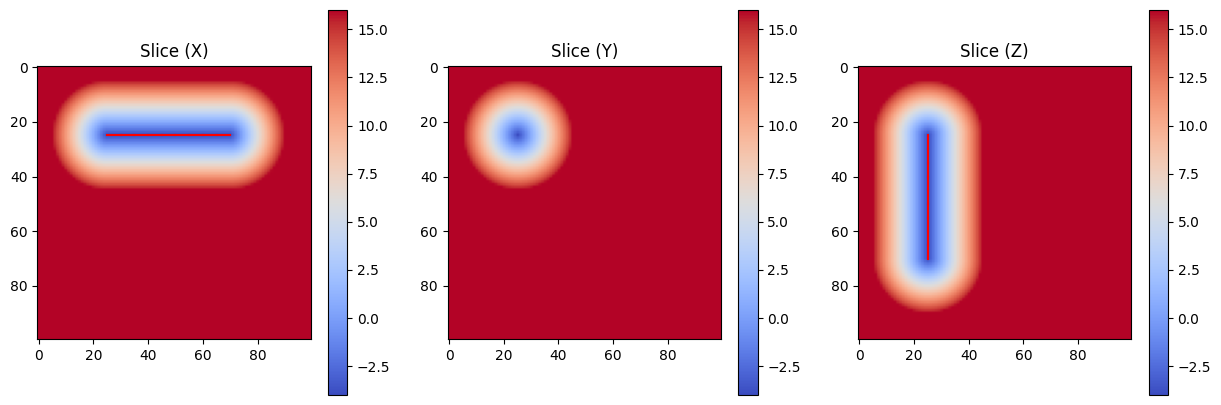

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\3080667750.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(torch.abs(di)), g)


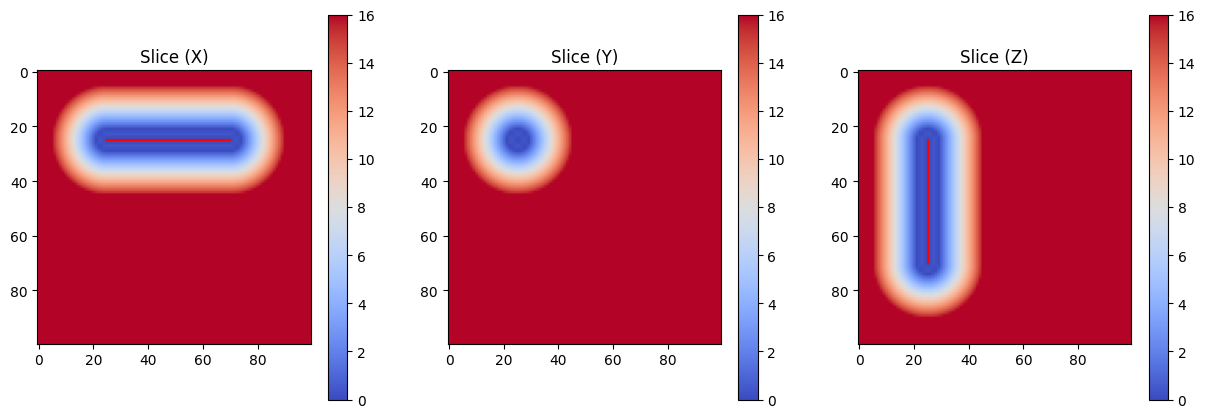

In [56]:
di = torch.clamp(distance_map, max=16)
show_slices(np.array(di), g)
show_slices(np.array(torch.abs(di)), g)

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\1784994802.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  d = np.array(distance_map)


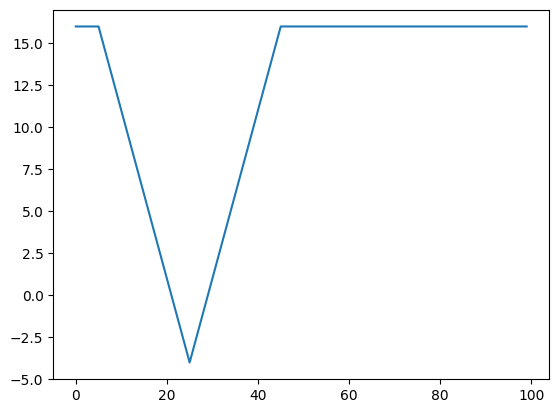

In [57]:
d = np.array(distance_map)
d = np.min(d, axis=2)
plt.plot(d[:,50])

In [58]:
fltr = makeGaussEdgeFltr(1.0,3)
fltrtr = th.from_numpy(fltr).type(th.float32)

predv = di.clone()[None,None]
predw = th.abs(di).clone()[None,None]

gimgv = cmptGradIm(predv,fltrtr)
gimgw = cmptGradIm(predw,fltrtr)

gimgv = gimgv[0]
gimgw = gimgw[0]

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\2498065466.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[0]), g)


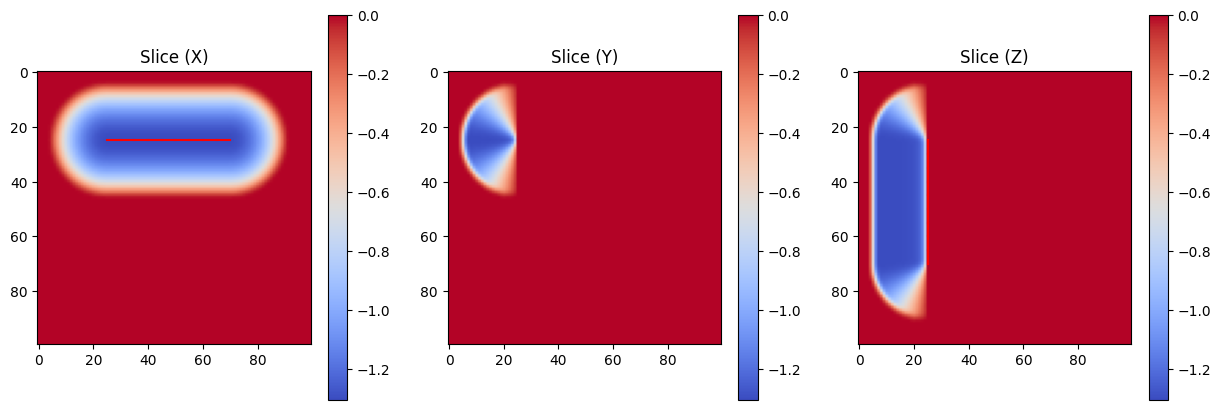

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\2498065466.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[1]), g)


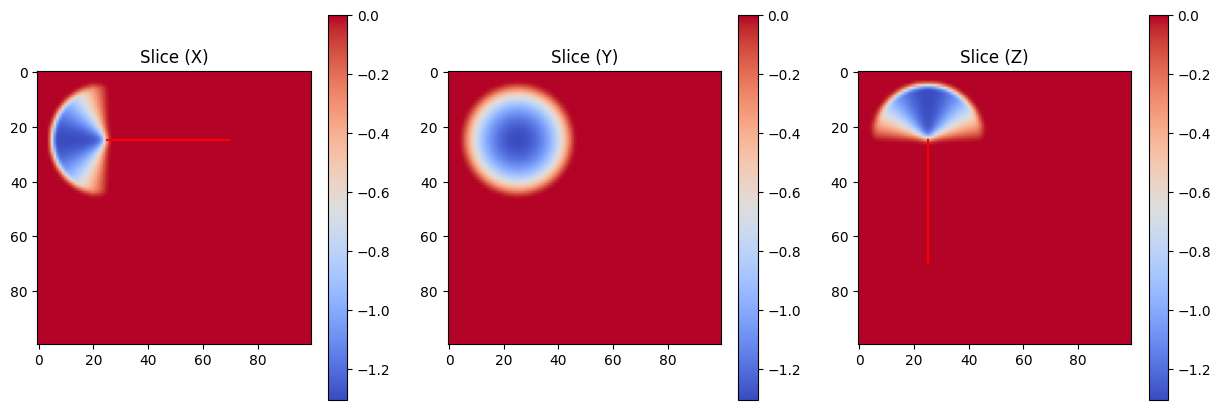

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\2498065466.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[2]), g)


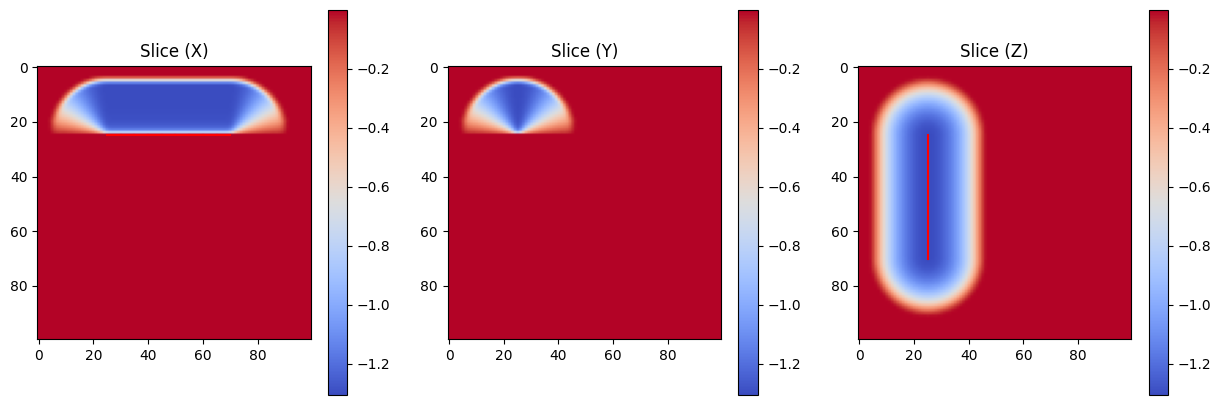

In [59]:
show_slices(np.array(gimgv[0]), g)
show_slices(np.array(gimgv[1]), g)
show_slices(np.array(gimgv[2]), g)

In [60]:
croprib=[slice(0,200), slice(0,200), slice(0,200)]
g = nx.Graph()
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([25, i, 25]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([10,0,0])

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\2977832577.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(predv[0][0]), g)


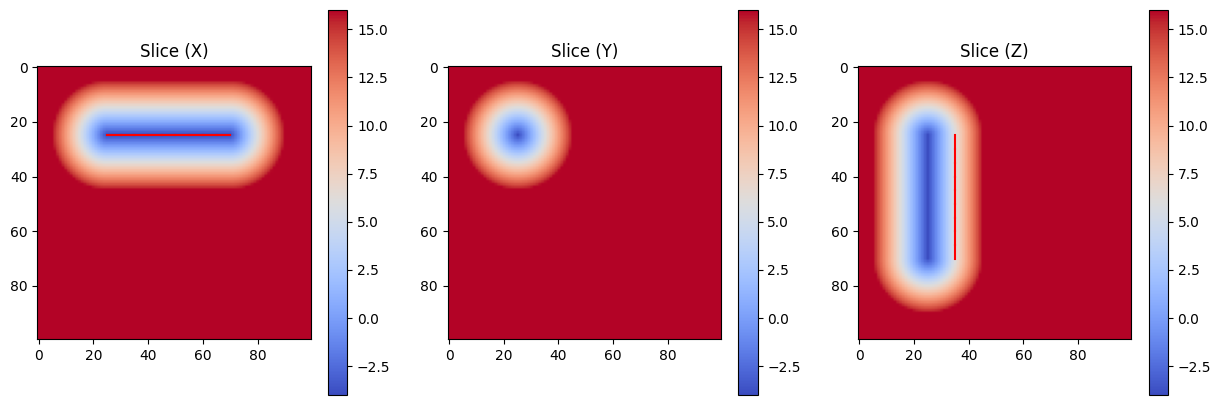

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\2977832577.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(predv[0][0]), sa.getGraph())


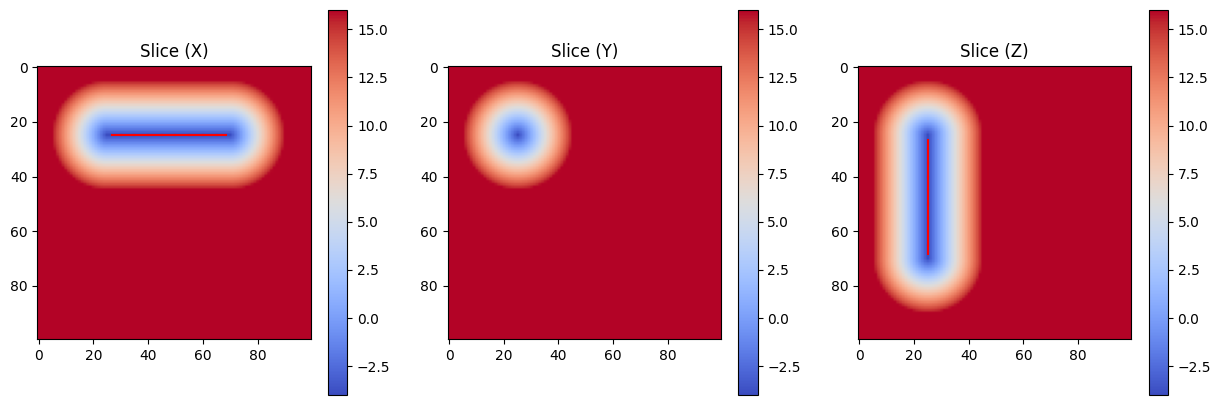

In [61]:
dim=3
sa = GradImRib(g,crop,stepsz,alpha,beta,dim,gimgv,gimgw)
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)
# Plot the image
show_slices(np.array(predv[0][0]), g)

last = sa.optim(150)
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)

# Get the final positions of the snake nodes
show_slices(np.array(predv[0][0]), sa.getGraph())

In [62]:
sa.get_w()

tensor([4.4878, 7.1935, 7.7134, 7.7134, 7.7134, 7.7134, 7.7134, 7.7134, 7.1102,
        4.2324])

In [63]:
res_d = sa.render_distance_map_with_widths((100,100,100))

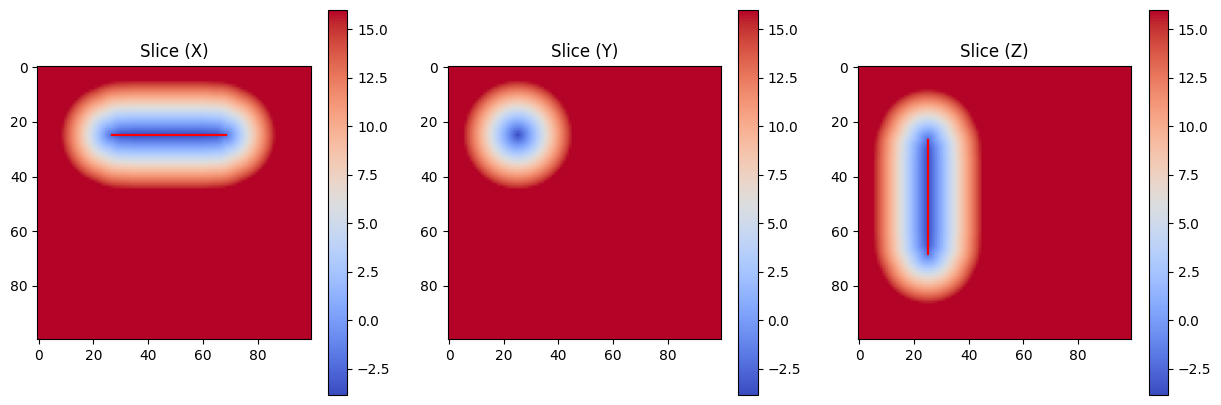

In [64]:
show_slices(res_d.detach().numpy(), sa.getGraph())

# X

In [65]:
g = nx.Graph()
widths = th.tensor([8.0]*10,dtype=th.float32)
#widths = th.tensor([5.0,5.0,6.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0], dtype=th.float32)
# az samplelayınca ve 
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([i, 25, 25]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0.0
beta = 0.0
crop = [slice(0, 200), slice(0, 200), slice(0, 200)]
ndims = 3

s = RibbonSnake(g, crop, stepsz, alpha, beta, dim=ndims)
s.set_w(widths.clone().detach().view(-1, 1))

In [66]:
distance_map = s.render_distance_map_with_widths((100,100,100))

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\3080667750.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(di), g)


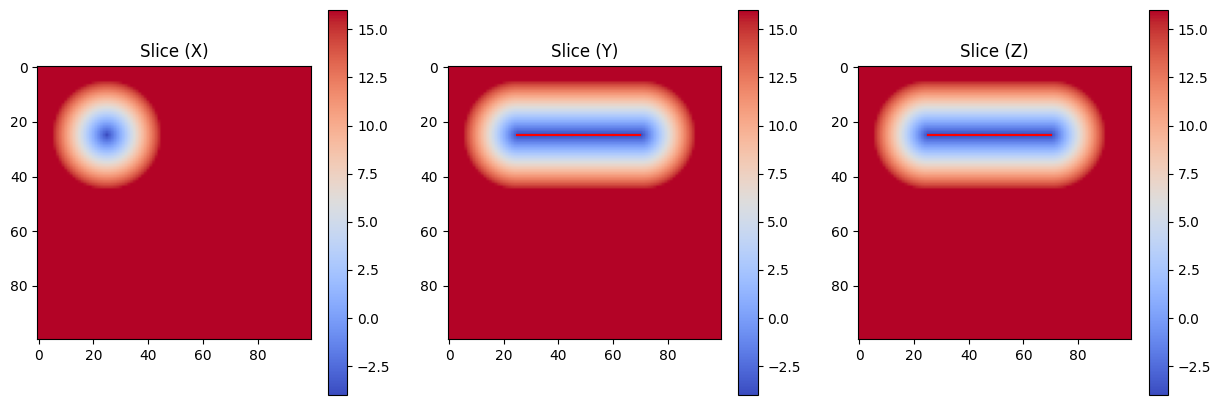

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\3080667750.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(torch.abs(di)), g)


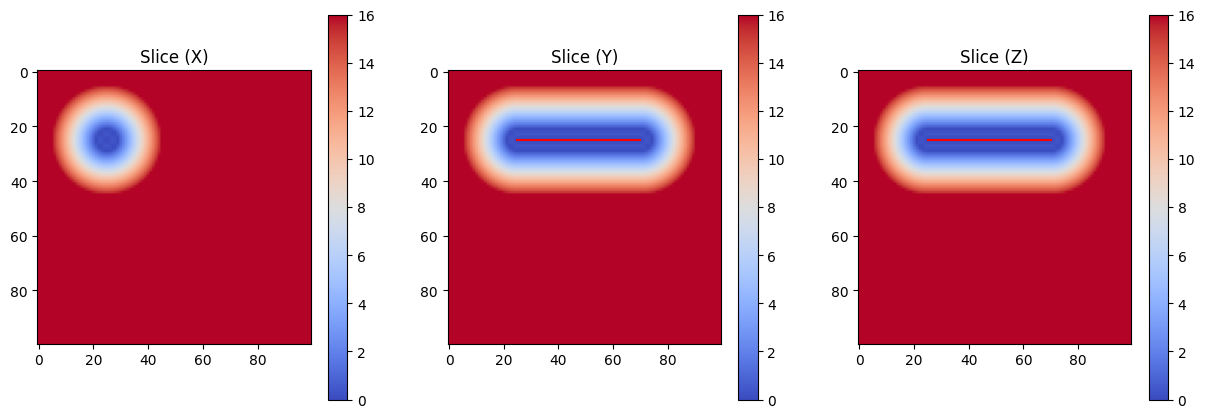

In [67]:
di = torch.clamp(distance_map, max=16)
show_slices(np.array(di), g)
show_slices(np.array(torch.abs(di)), g)

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\1784994802.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  d = np.array(distance_map)


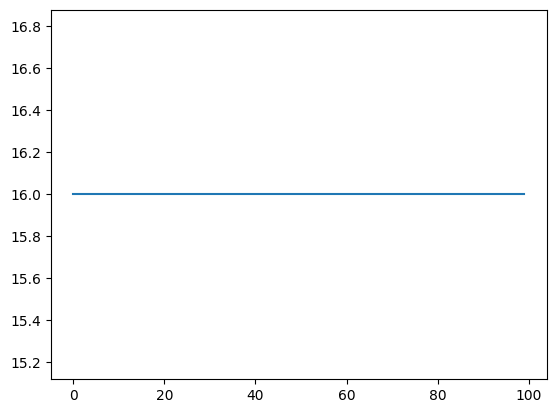

In [68]:
d = np.array(distance_map)
d = np.min(d, axis=2)
plt.plot(d[:,50])

In [69]:
fltr = makeGaussEdgeFltr(1.0,3)
fltrtr = th.from_numpy(fltr).type(th.float32)

predv = di.clone()[None,None]
predw = th.abs(di).clone()[None,None]

gimgv = cmptGradIm(predv,fltrtr)
gimgw = cmptGradIm(predw,fltrtr)

gimgv = gimgv[0]
gimgw = gimgw[0]

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\2498065466.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[0]), g)


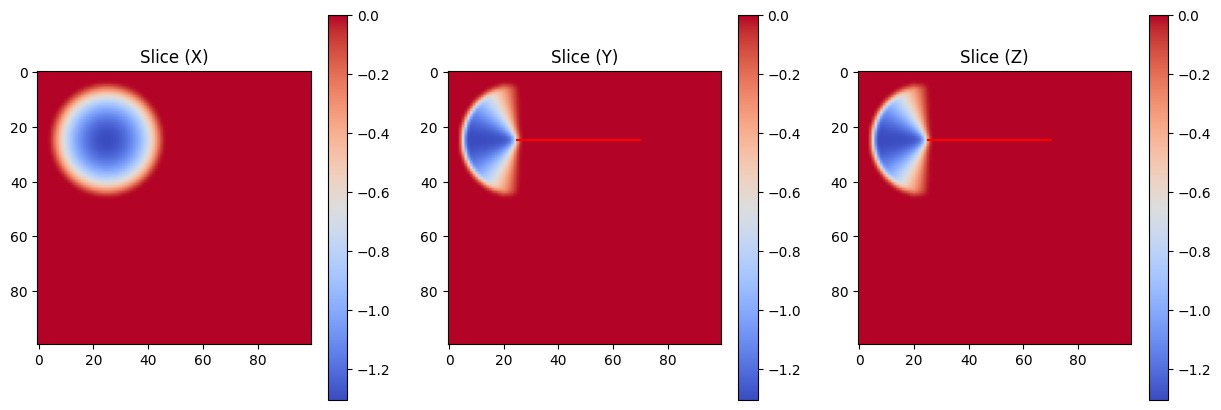

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\2498065466.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[1]), g)


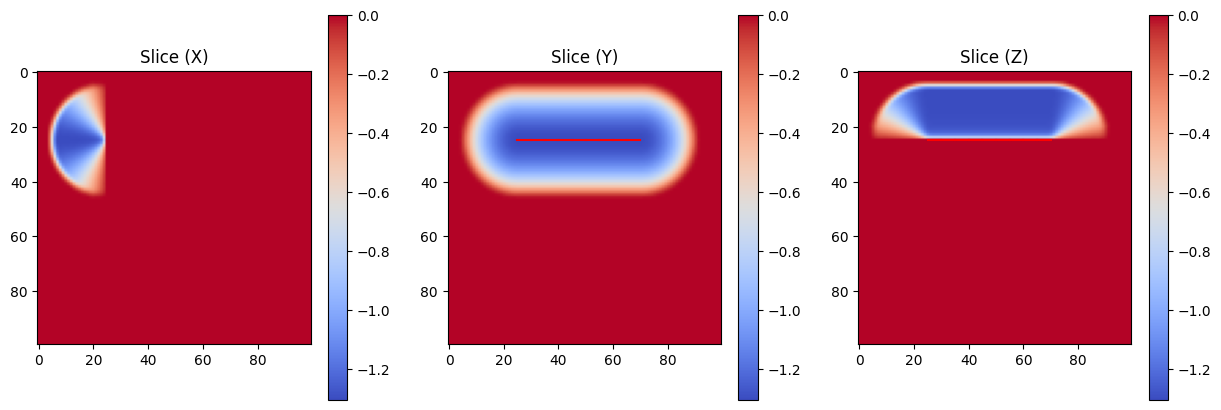

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\2498065466.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[2]), g)


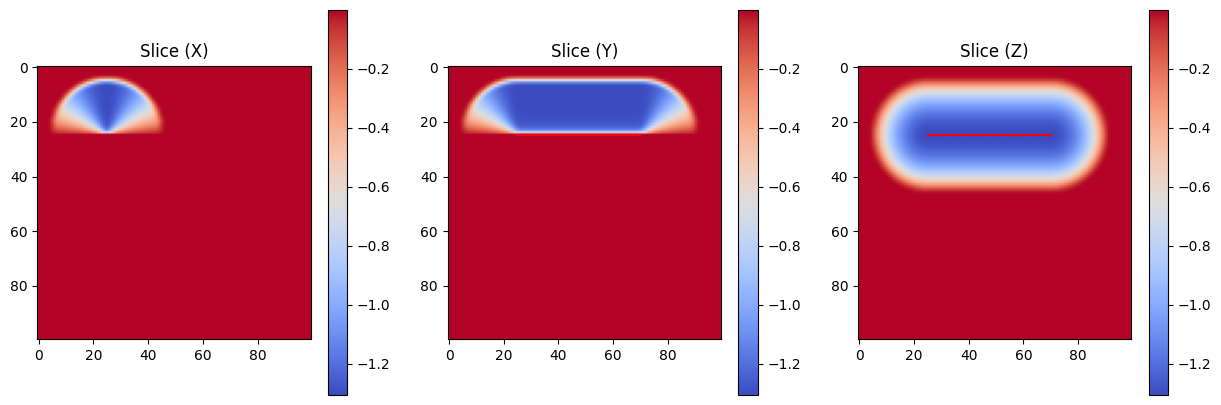

In [70]:
show_slices(np.array(gimgv[0]), g)
show_slices(np.array(gimgv[1]), g)
show_slices(np.array(gimgv[2]), g)

In [71]:
croprib=[slice(0,200), slice(0,200), slice(0,200)]
g = nx.Graph()
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([i, 25, 25]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([0,0,10])

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\2977832577.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(predv[0][0]), g)


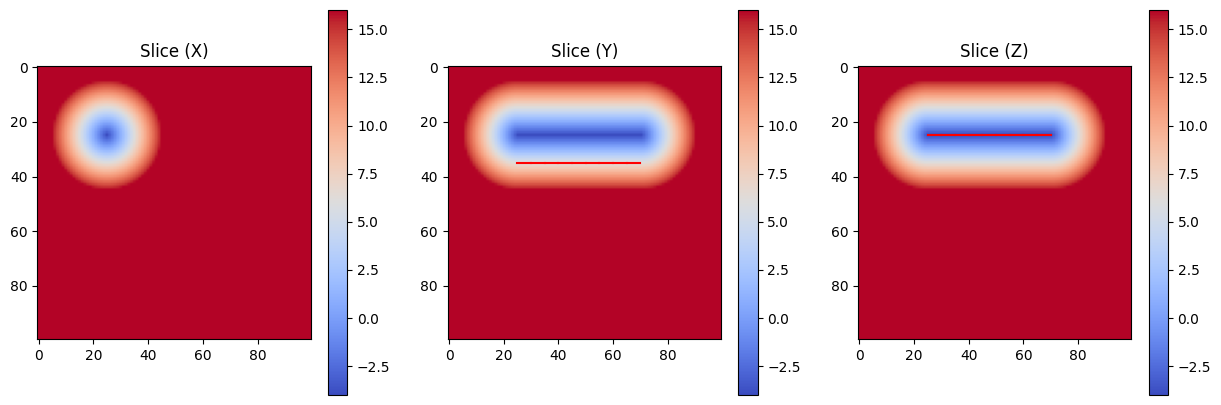

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\2977832577.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(predv[0][0]), sa.getGraph())


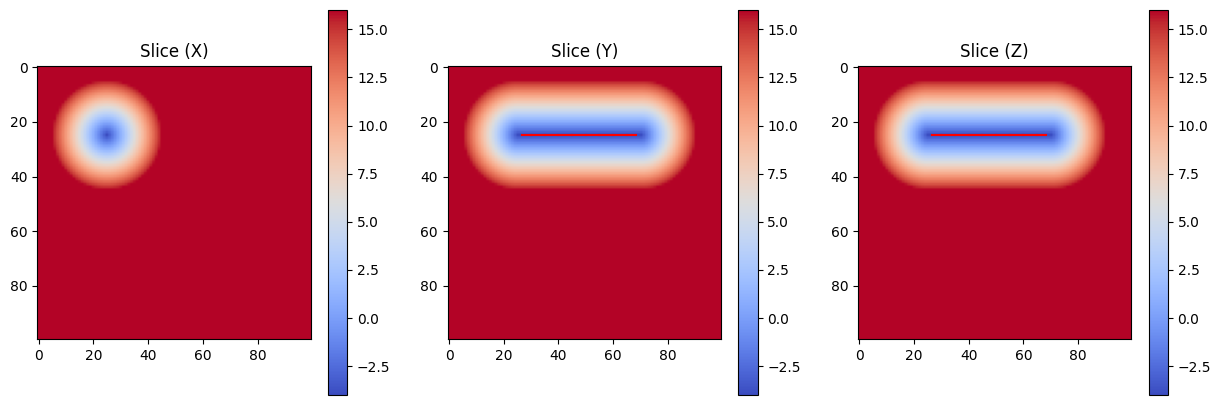

In [72]:
dim=3
sa = GradImRib(g,crop,stepsz,alpha,beta,dim,gimgv,gimgw)
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)
# Plot the image
show_slices(np.array(predv[0][0]), g)

last = sa.optim(150)
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)

# Get the final positions of the snake nodes
show_slices(np.array(predv[0][0]), sa.getGraph())

In [73]:
sa.get_w()

tensor([5.0999, 7.3219, 7.7134, 7.7134, 7.7134, 7.7134, 7.7134, 7.5983, 6.6646,
        4.0659])

In [74]:
res_d = sa.render_distance_map_with_widths((100,100,100))

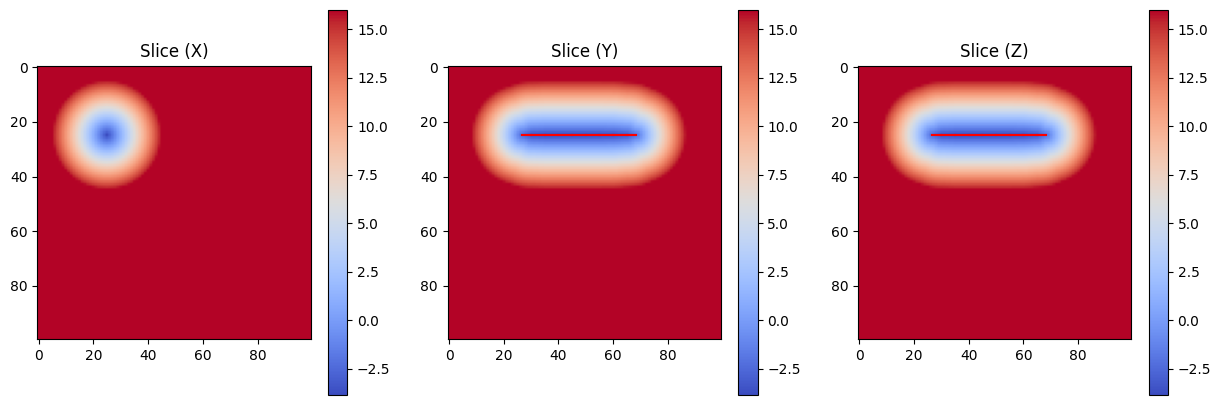

In [75]:
show_slices(res_d.detach().numpy(), sa.getGraph())

# Z

In [76]:
g = nx.Graph()
widths = th.tensor([8.0]*10,dtype=th.float32)
#widths = th.tensor([5.0,5.0,6.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0], dtype=th.float32)
# az samplelayınca ve 
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([25, 25, i]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0.0
beta = 0.0
crop = [slice(0, 200), slice(0, 200), slice(0, 200)]
ndims = 3

s = RibbonSnake(g, crop, stepsz, alpha, beta, dim=ndims)
s.set_w(widths.clone().detach().view(-1, 1))

In [77]:
distance_map = s.render_distance_map_with_widths((100,100,100))

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\3080667750.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(di), g)


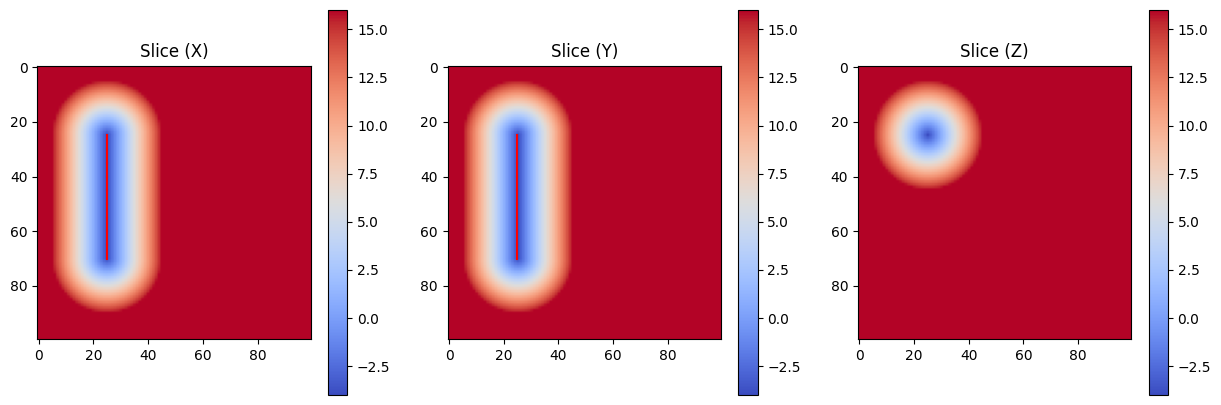

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\3080667750.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(torch.abs(di)), g)


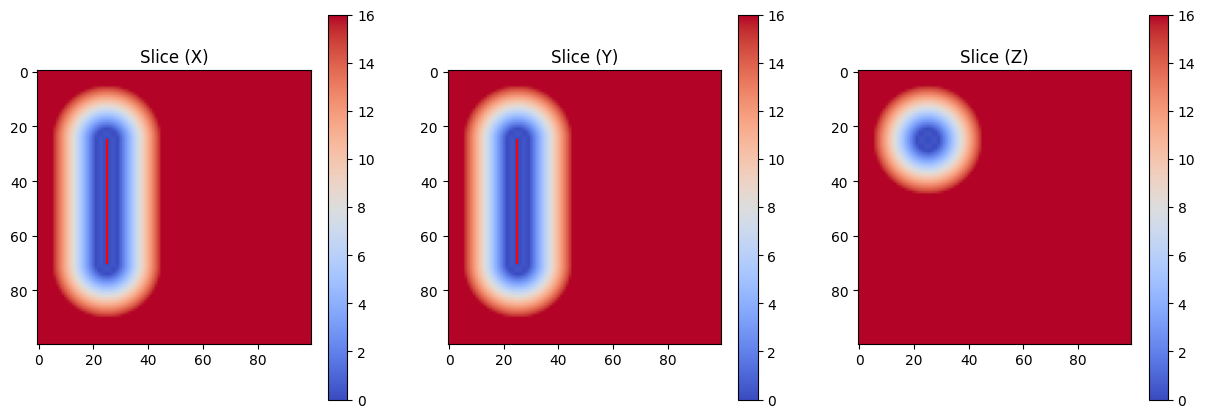

In [78]:
di = torch.clamp(distance_map, max=16)
show_slices(np.array(di), g)
show_slices(np.array(torch.abs(di)), g)

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\1784994802.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  d = np.array(distance_map)


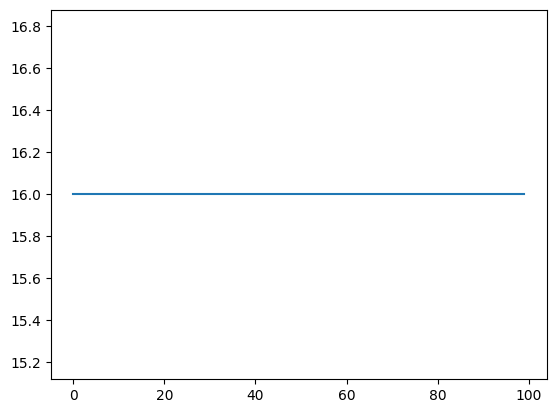

In [79]:
d = np.array(distance_map)
d = np.min(d, axis=2)
plt.plot(d[:,50])

In [80]:
fltr = makeGaussEdgeFltr(1.0,3)
fltrtr = th.from_numpy(fltr).type(th.float32)

predv = di.clone()[None,None]
predw = th.abs(di).clone()[None,None]

gimgv = cmptGradIm(predv,fltrtr)
gimgw = cmptGradIm(predw,fltrtr)

gimgv = gimgv[0]
gimgw = gimgw[0]

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\2498065466.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[0]), g)


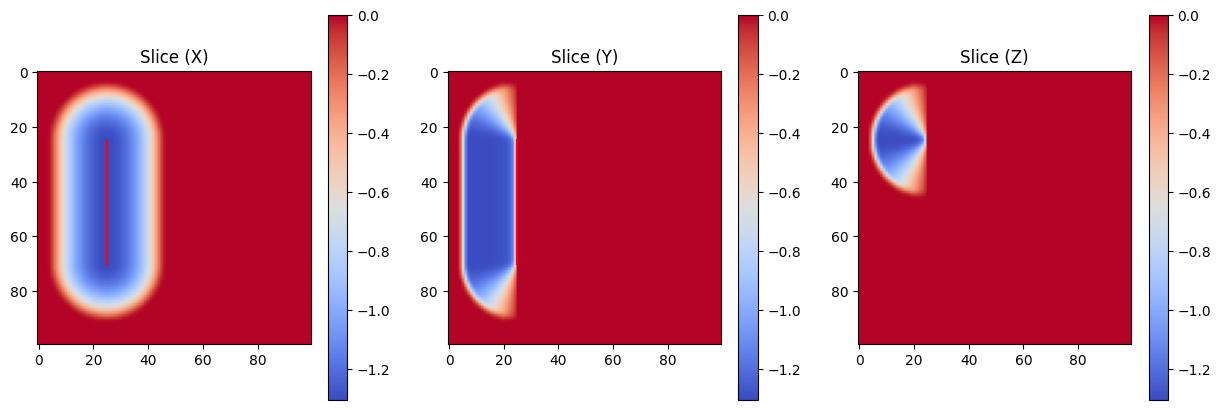

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\2498065466.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[1]), g)


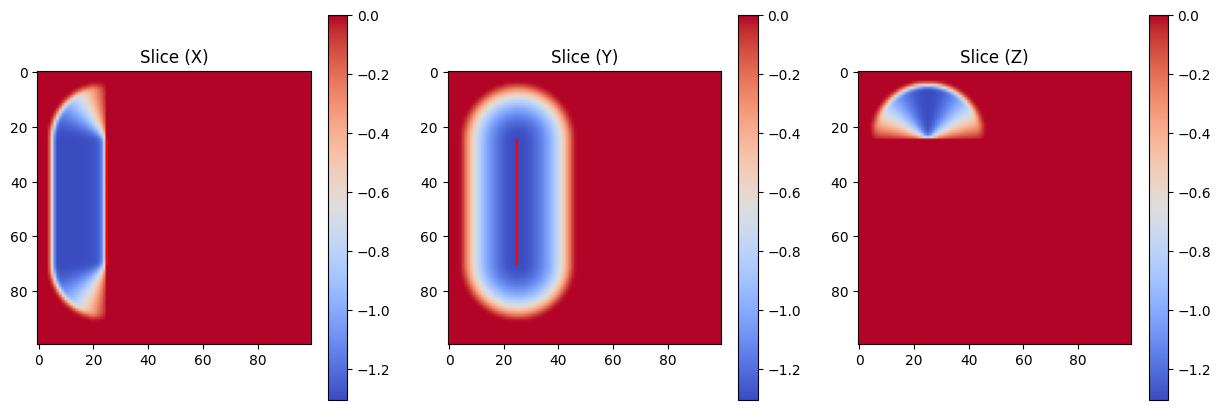

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\2498065466.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[2]), g)


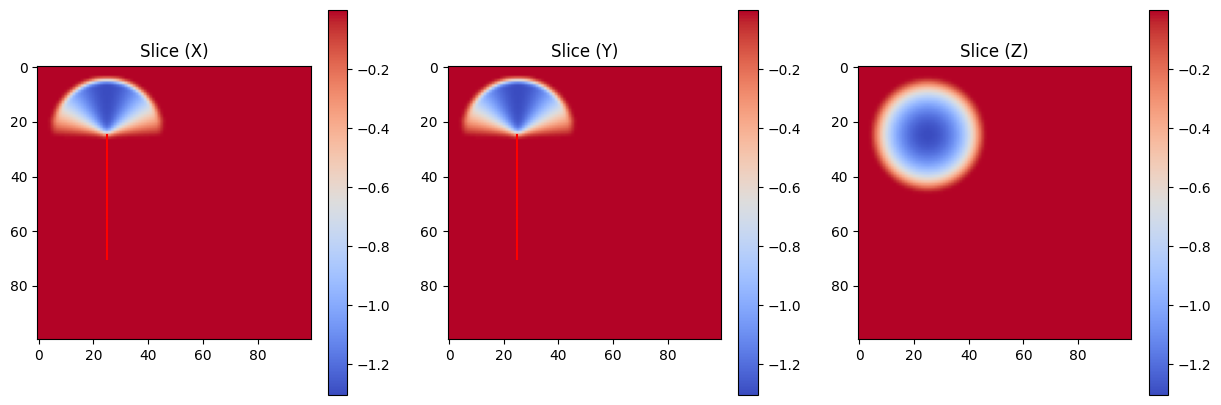

In [81]:
show_slices(np.array(gimgv[0]), g)
show_slices(np.array(gimgv[1]), g)
show_slices(np.array(gimgv[2]), g)

In [84]:
croprib=[slice(0,200), slice(0,200), slice(0,200)]
g = nx.Graph()
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([25, 25, i]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([0,0,10])

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\2977832577.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(predv[0][0]), g)


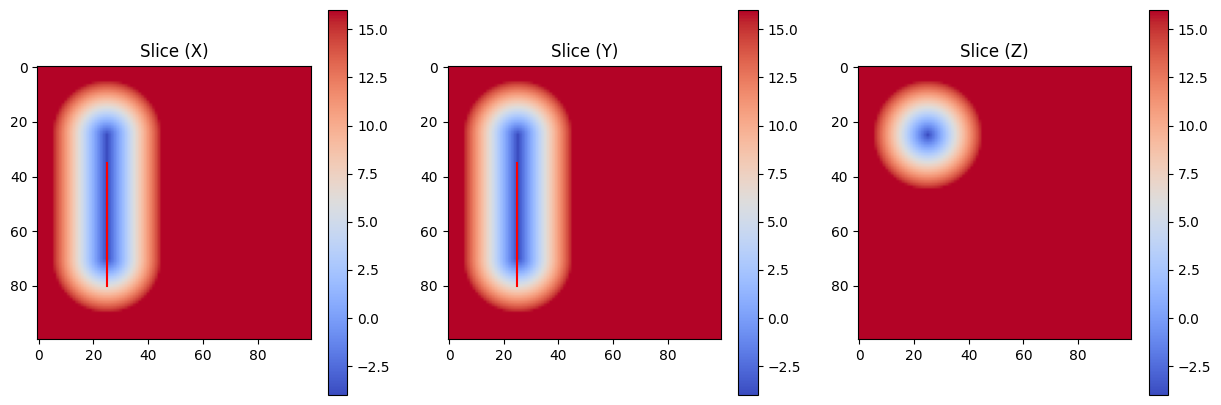

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\2977832577.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(predv[0][0]), sa.getGraph())


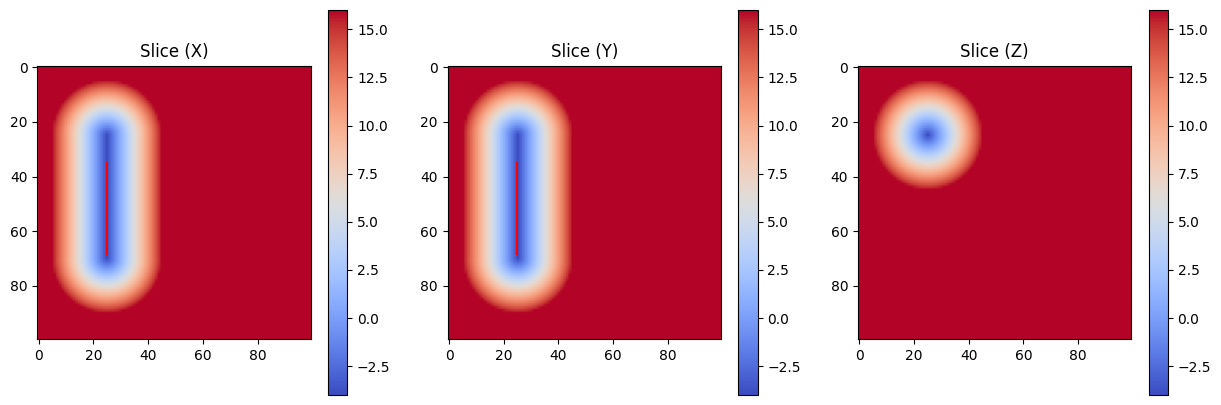

In [85]:
dim=3
sa = GradImRib(g,crop,stepsz,alpha,beta,dim,gimgv,gimgw)
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)
# Plot the image
show_slices(np.array(predv[0][0]), g)

last = sa.optim(150)
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)

# Get the final positions of the snake nodes
show_slices(np.array(predv[0][0]), sa.getGraph())

In [86]:
sa.get_w()

tensor([4.6396, 7.2506, 7.7134, 7.7134, 7.7134, 7.7134, 7.6550, 7.2738, 6.3263,
        4.1241])

# XYZ

In [87]:
g = nx.Graph()
widths = th.tensor([8.0]*10,dtype=th.float32)
#widths = th.tensor([5.0,5.0,6.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0], dtype=th.float32)
# az samplelayınca ve 
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([i, i, i]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0.0
beta = 0.0
crop = [slice(0, 200), slice(0, 200), slice(0, 200)]
ndims = 3

s = RibbonSnake(g, crop, stepsz, alpha, beta, dim=ndims)
s.set_w(widths.clone().detach().view(-1, 1))

In [88]:
distance_map = s.render_distance_map_with_widths((100,100,100))

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\3080667750.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(di), g)


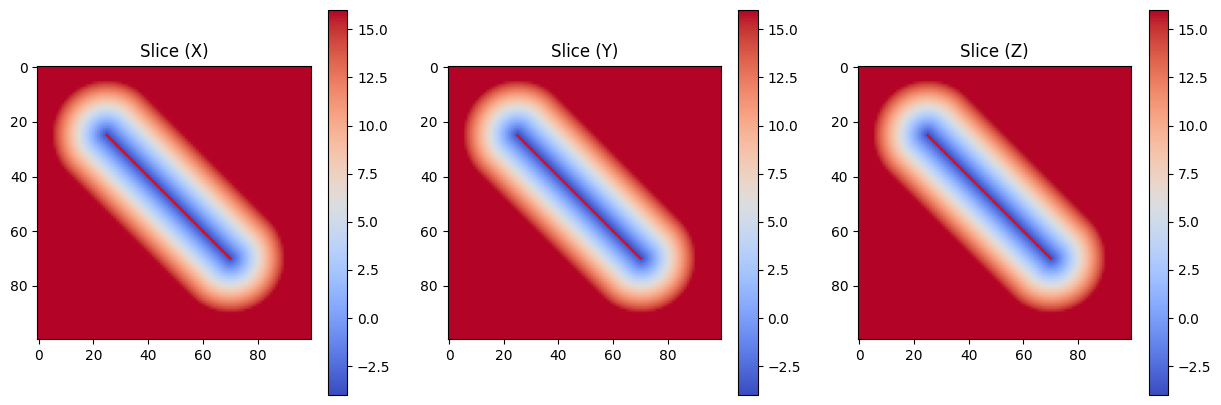

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\3080667750.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(torch.abs(di)), g)


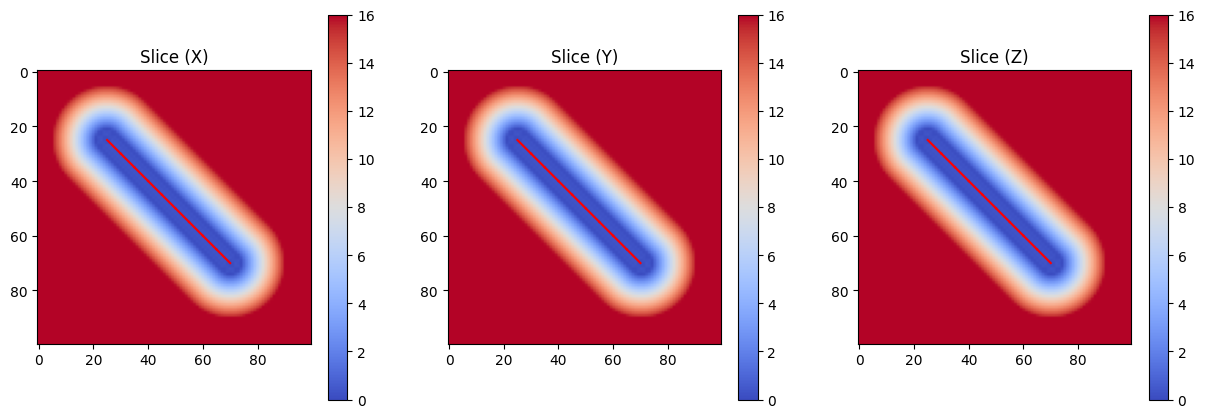

In [89]:
di = torch.clamp(distance_map, max=16)
show_slices(np.array(di), g)
show_slices(np.array(torch.abs(di)), g)

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\1784994802.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  d = np.array(distance_map)


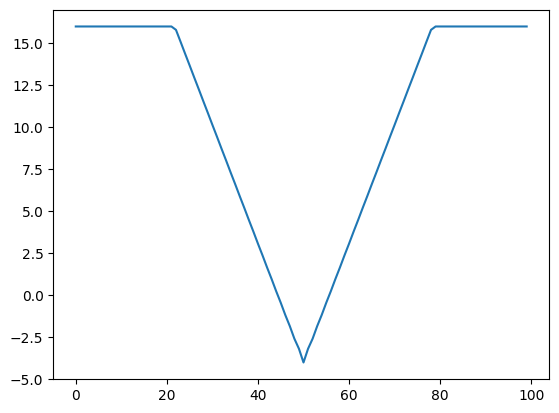

In [90]:
d = np.array(distance_map)
d = np.min(d, axis=2)
plt.plot(d[:,50])

In [91]:
fltr = makeGaussEdgeFltr(1.0,3)
fltrtr = th.from_numpy(fltr).type(th.float32)

predv = di.clone()[None,None]
predw = th.abs(di).clone()[None,None]

gimgv = cmptGradIm(predv,fltrtr)
gimgw = cmptGradIm(predw,fltrtr)

gimgv = gimgv[0]
gimgw = gimgw[0]

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\2498065466.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[0]), g)


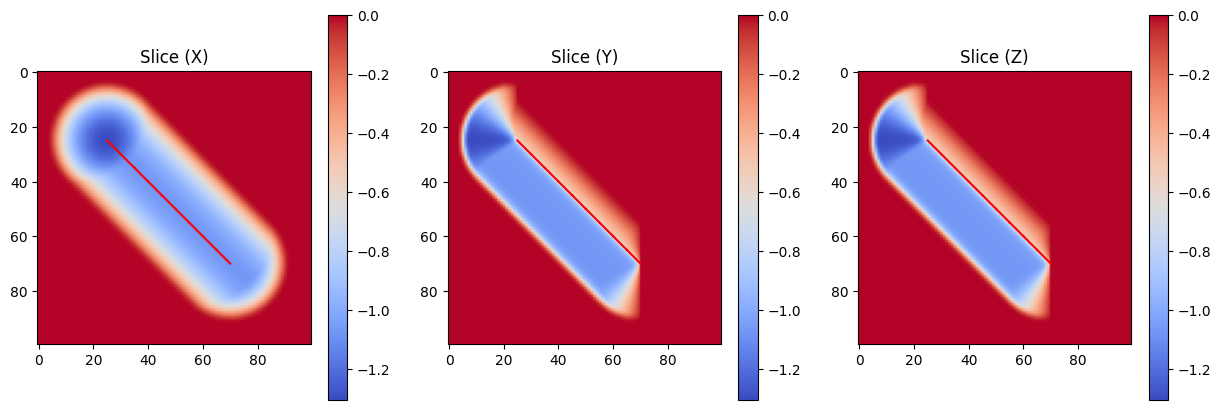

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\2498065466.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[1]), g)


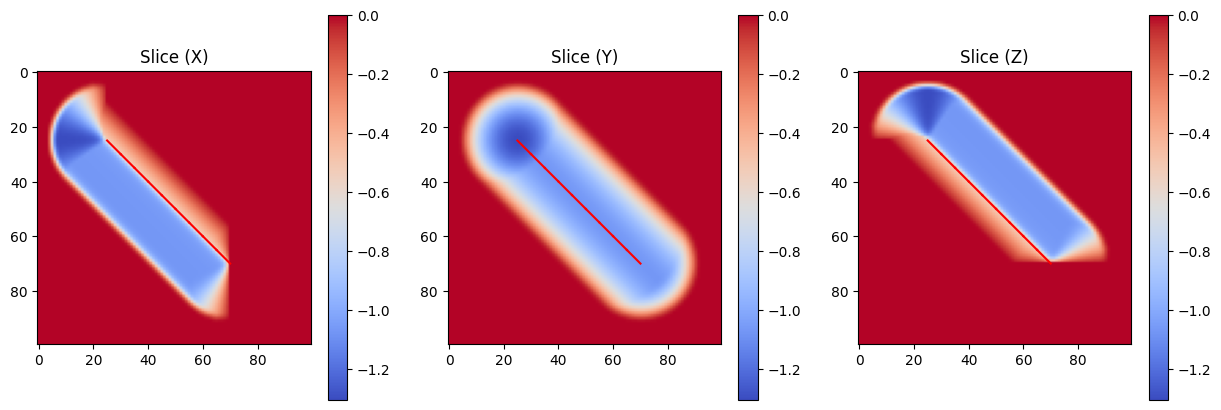

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\2498065466.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[2]), g)


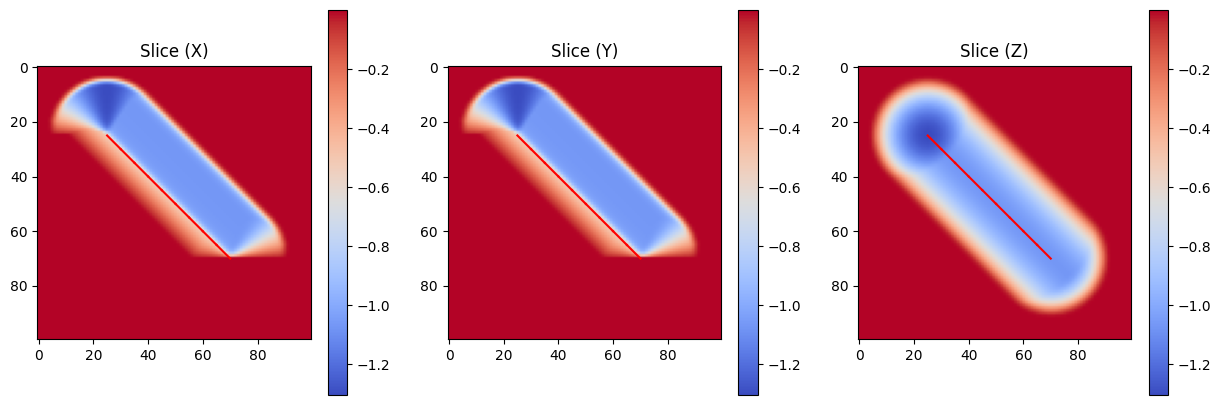

In [92]:
show_slices(np.array(gimgv[0]), g)
show_slices(np.array(gimgv[1]), g)
show_slices(np.array(gimgv[2]), g)

In [93]:
g = nx.Graph()
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([i, i, i]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([0,0,10])

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\2977832577.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(predv[0][0]), g)


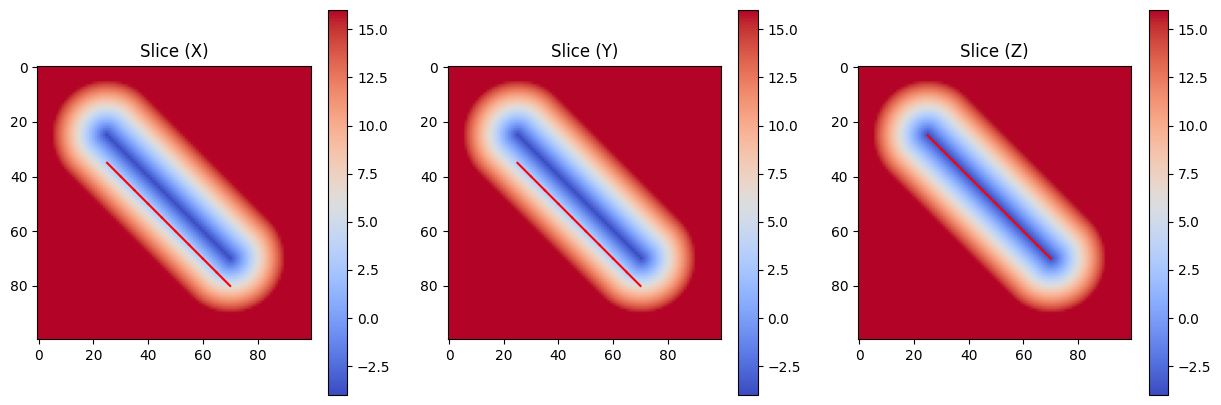

C:\Users\serta\AppData\Local\Temp\ipykernel_3128\2977832577.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(predv[0][0]), sa.getGraph())


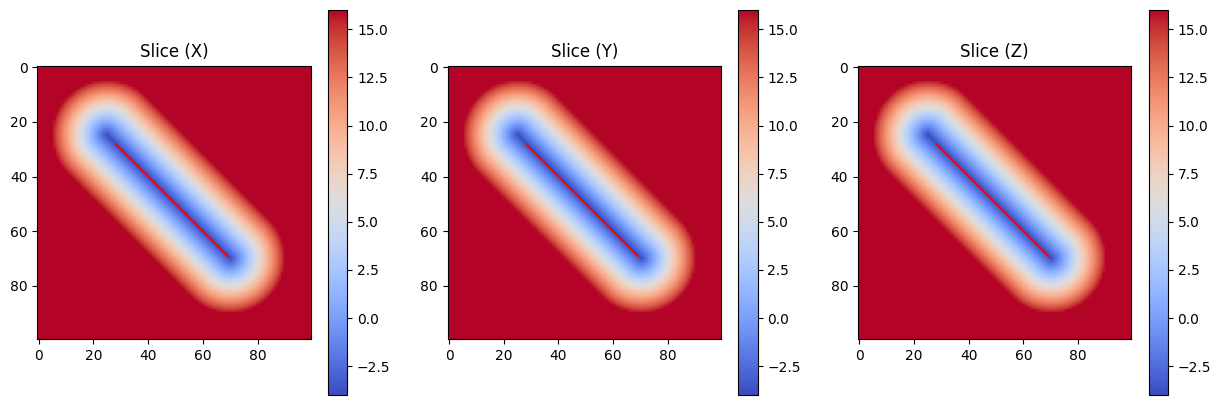

In [94]:
dim=3
sa = GradImRib(g,crop,stepsz,alpha,beta,dim,gimgv,gimgw)
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)
# Plot the image
show_slices(np.array(predv[0][0]), g)

last = sa.optim(150)
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)

# Get the final positions of the snake nodes
show_slices(np.array(predv[0][0]), sa.getGraph())

In [95]:
sa.get_w()

tensor([4.7562, 6.9533, 7.6455, 7.7038, 7.7038, 7.7038, 7.7038, 7.6780, 6.9710,
        4.3527])

In [ ]:
sa.get_w()

tensor([4.6396, 7.2506, 7.7134, 7.7134, 7.7134, 7.7134, 7.6550, 7.2738, 6.3263,
        4.1241])

In [271]:
sa.get_w()

tensor([[7.6930],
        [7.7038],
        [7.7038],
        [7.7038],
        [7.7038],
        [7.7038],
        [7.7038],
        [7.7038],
        [7.7038],
        [7.7037]])

# SIN

In [289]:
widths = th.tensor([5.0]*50,dtype=th.float32)
g=nx.Graph()
for i in range(25,75):
    g.add_node(i,pos=np.array([i,i, sin(i*2*pi/50.0)*25+50]))
    if i>25:
        g.add_edge(i,i-1)
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0.0
beta = 0.0
crop = [slice(0, 200), slice(0, 200), slice(0, 200)]
ndims = 3

s = RibbonSnake(g, crop, stepsz, alpha, beta, None, None, ndims=ndims)
s.set_w(widths.clone().detach().view(-1, 1))

gra = s.getGraph()
nodes = [gra.nodes[n]['pos'] for n in gra.nodes()]
widths = s.get_w().flatten()
samples_to_widths = list(zip(nodes, widths))

norms_perf, norms2, tangents = s._compute_normals_complex(s.s)

centers = np.array([c for c, _ in samples_to_widths], dtype=np.float32)
widths = np.array([w for _, w in samples_to_widths], dtype=np.float32)
normals = np.array(norms_perf, dtype=np.float32)
tangents = np.array(tangents)

def create_circle(center, tangent, radius, normal, num_points=50):
    u = np.cross(tangent, normal)
    u = u / np.linalg.norm(u)    

    angles = np.linspace(0, 2 * np.pi, num_points)
    circle_points = np.array([center + radius * (np.cos(a) * u + np.sin(a) * normal)
                              for a in angles])
    return circle_points

circles = []
num_centers = len(centers)

for i in range(num_centers):
    center = centers[i]
    radius = widths[i]
    tangent = tangents[i]
    normal = normals[i]
    
    circle = create_circle(center, tangent, radius, normal)
    circles.append(circle)

C:\Users\serta\AppData\Local\Temp\ipykernel_32280\2807868270.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  normals = np.array(norms_perf, dtype=np.float32)


In [290]:
params = calculate_grid_parameters(centers, widths, padding=10, voxel_resolution=1.0)

In [291]:
distance_map = compute_3d_distance_map(
    centers, widths, tangents, normals,
    grid_shape=params['grid_shape'],
    voxel_size=params['voxel_size'],
    origin=params['origin']
)

C:\Users\serta\AppData\Local\Temp\ipykernel_32280\3080667750.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(di), g)


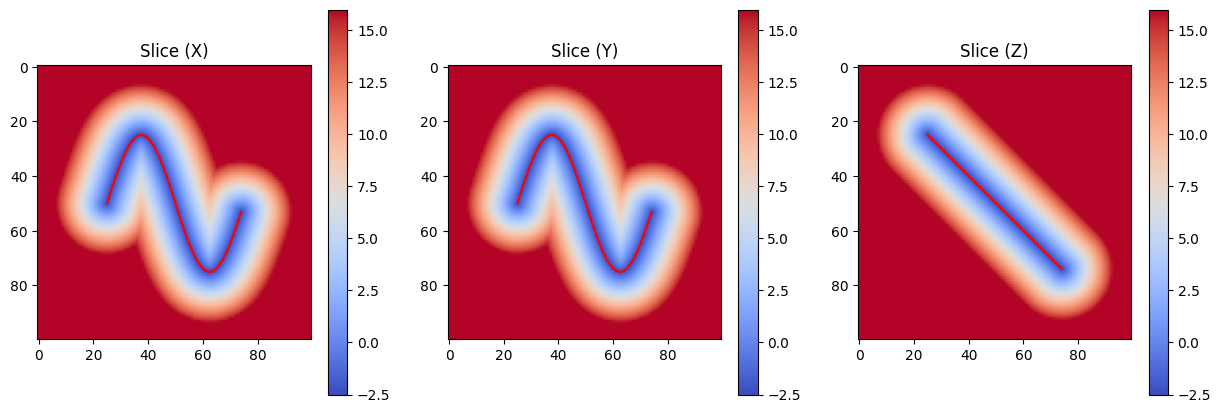

C:\Users\serta\AppData\Local\Temp\ipykernel_32280\3080667750.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(torch.abs(di)), g)


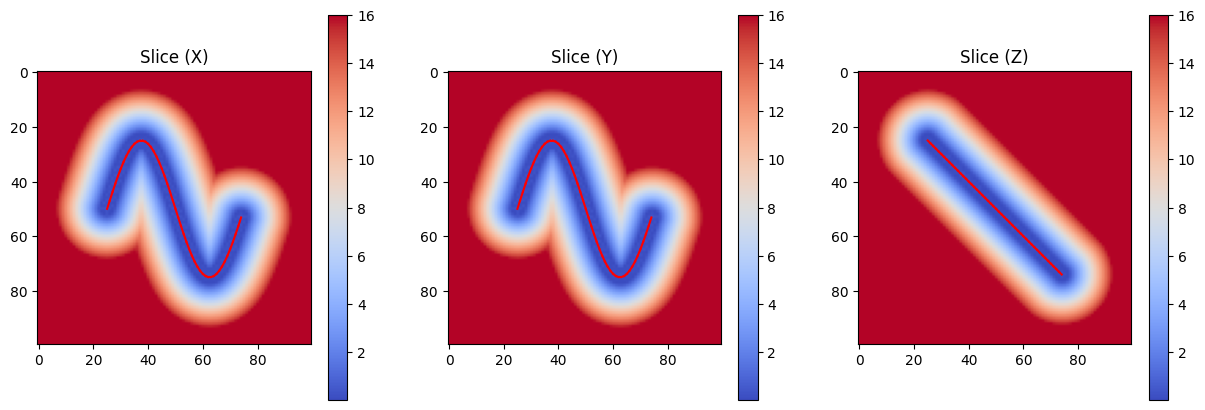

In [292]:
di = torch.clamp(distance_map, max=16)
show_slices(np.array(di), g)
show_slices(np.array(torch.abs(di)), g)

C:\Users\serta\AppData\Local\Temp\ipykernel_32280\1784994802.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  d = np.array(distance_map)


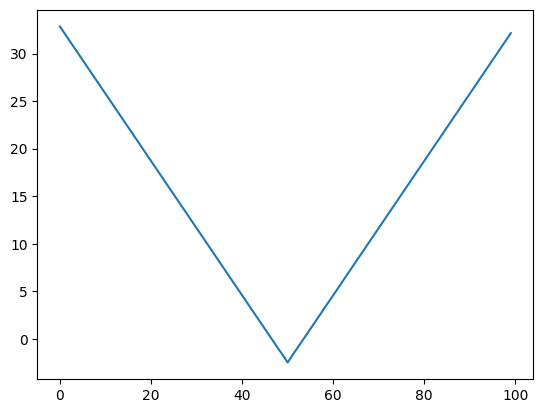

In [293]:
d = np.array(distance_map)
d = np.min(d, axis=2)
plt.plot(d[:,50])

In [294]:
fltr = makeGaussEdgeFltr(1.0,3)
fltrtr = th.from_numpy(fltr).type(th.float32)

predv = di.clone()[None,None]
predw = th.abs(di).clone()[None,None]

gimgv = cmptGradIm(predv,fltrtr)
gimgw = cmptGradIm(predw,fltrtr)

gimgv = gimgv[0]
gimgw = gimgw[0]

C:\Users\serta\AppData\Local\Temp\ipykernel_32280\2498065466.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[0]), g)


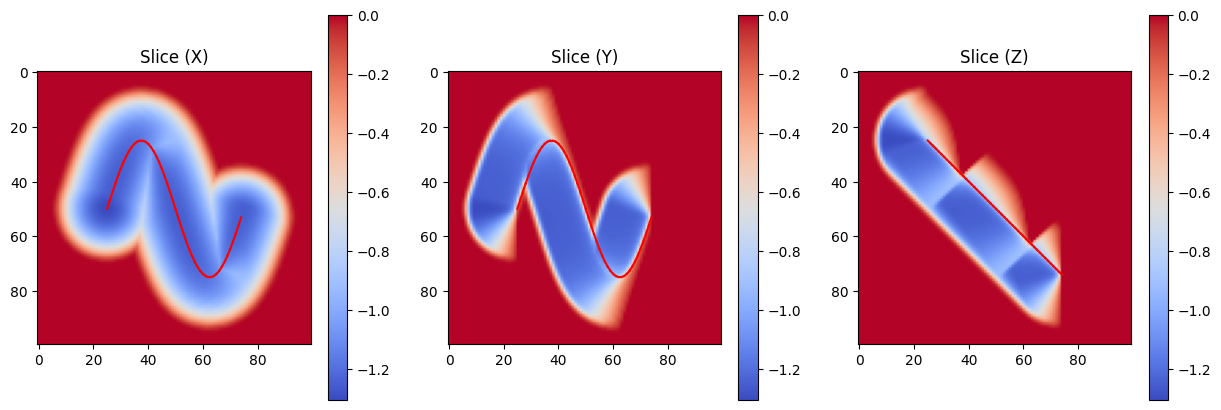

C:\Users\serta\AppData\Local\Temp\ipykernel_32280\2498065466.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[1]), g)


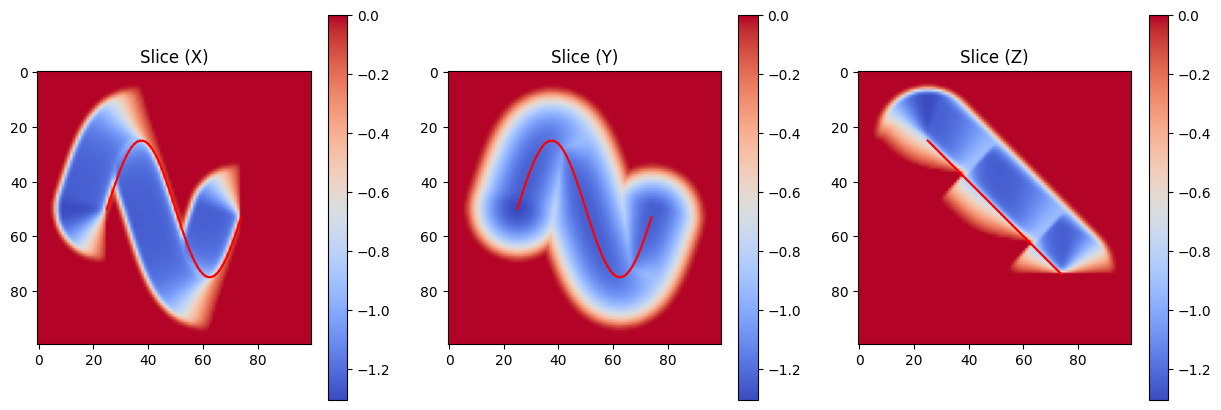

C:\Users\serta\AppData\Local\Temp\ipykernel_32280\2498065466.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[2]), g)


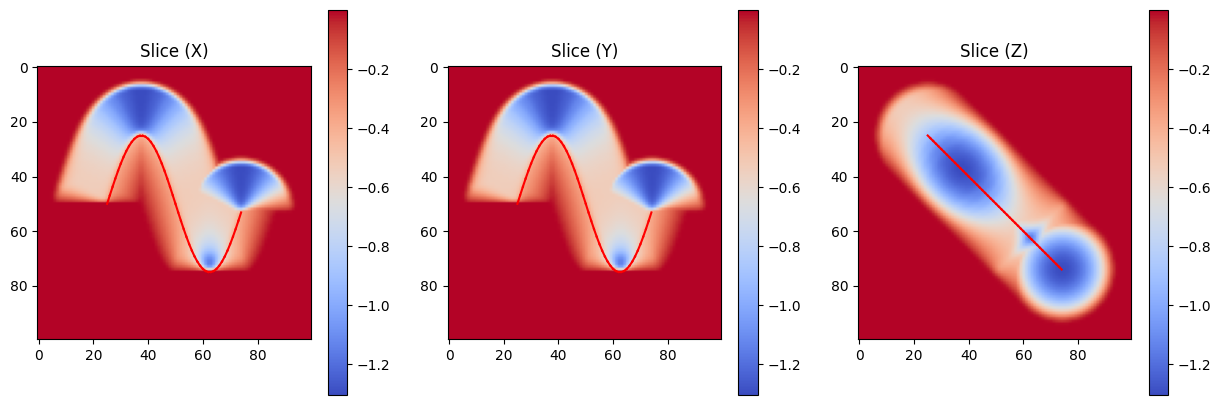

In [295]:
show_slices(np.array(gimgv[0]), g)
show_slices(np.array(gimgv[1]), g)
show_slices(np.array(gimgv[2]), g)

In [296]:
croprib=[slice(0,200), slice(0,200), slice(0,200)]
g=nx.Graph()
for i in range(25,75):
    g.add_node(i,pos=np.array([i,i, sin(i*2*pi/50.0)*25+50]))
    if i>25:
        g.add_edge(i,i-1)
for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([4,4,0])

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])


C:\Users\serta\AppData\Local\Temp\ipykernel_32280\1906394730.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(predv[0][0]), g)


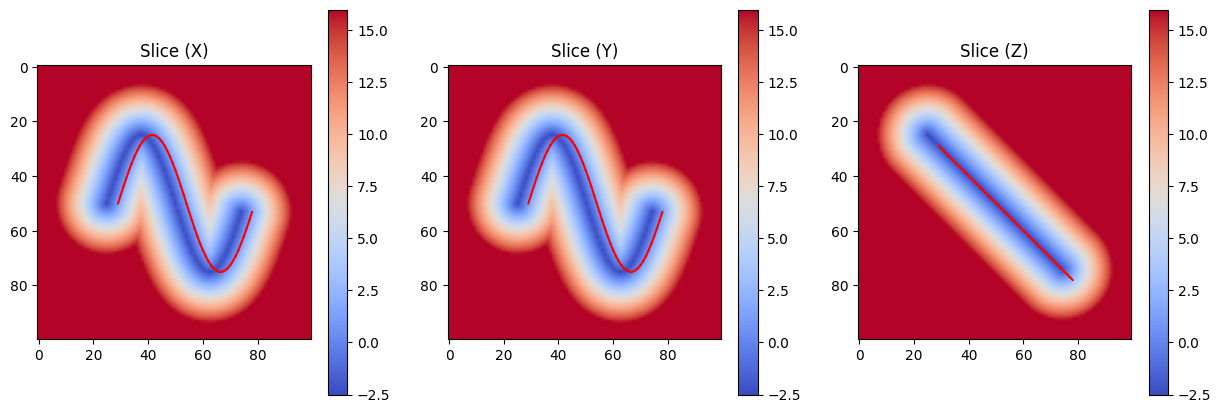

C:\Users\serta\AppData\Local\Temp\ipykernel_32280\1906394730.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(predv[0][0]), sa.getGraph())


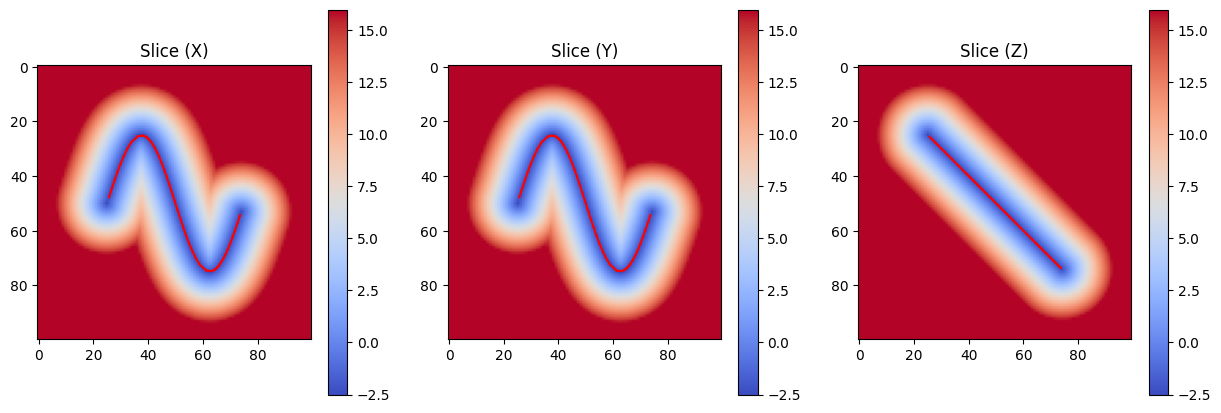

In [297]:
sa=RibbonSnake(g,croprib,stepsz,alpha,beta,gimgv, gimgw, step_type="original", ndims=3)
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)
# Plot the image
print(sa.get_w())
show_slices(np.array(predv[0][0]), g)

last = sa.optim(150)
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)

# Get the final positions of the snake nodes
show_slices(np.array(predv[0][0]), sa.getGraph())

In [298]:
sa.get_w()

tensor([[4.3714],
        [4.3723],
        [4.3756],
        [4.3861],
        [4.4048],
        [4.4109],
        [4.3961],
        [4.4356],
        [4.5298],
        [4.5822],
        [5.3513],
        [5.3086],
        [5.3111],
        [5.2798],
        [5.2209],
        [5.1887],
        [5.0300],
        [5.0028],
        [5.0116],
        [4.9682],
        [4.9238],
        [4.8944],
        [4.8595],
        [4.8342],
        [4.8273],
        [4.8205],
        [4.8313],
        [4.8634],
        [4.9113],
        [4.9570],
        [5.0282],
        [5.0384],
        [5.2739],
        [5.4481],
        [4.4964],
        [4.5290],
        [4.4963],
        [4.4857],
        [4.4535],
        [4.4294],
        [4.4352],
        [4.3946],
        [4.3789],
        [4.4047],
        [4.4109],
        [4.3965],
        [4.3797],
        [4.3744],
        [4.3526],
        [4.3428]])

# With Loss

In [34]:
import torch.nn as nn
import torch.optim as optim

In [48]:
class SnakeFastLoss(nn.Module):
    def __init__(self, stepsz,alpha,beta,fltrstdev,ndims,nsteps,
                       cropsz,dmax,maxedgelen,extgradfac):
        super(SnakeFastLoss,self).__init__()
        self.stepsz = stepsz
        self.alpha = alpha
        self.beta = beta
        self.fltrstdev = fltrstdev
        self.ndims = ndims
        self.cropsz = cropsz
        self.dmax = dmax
        self.maxedgelen = maxedgelen
        self.extgradfac = extgradfac
        self.nsteps = nsteps

        self.fltr = makeGaussEdgeFltr(self.fltrstdev,self.ndims)
        self.fltrt = torch.from_numpy(self.fltr).type(torch.float32)

        self.iscuda = False

    def cuda(self):
        super(SnakeFastLoss,self).cuda()
        self.fltrt = self.fltrt.cuda()
        self.iscuda = True
        return self

    def forward(self,pred_dmap,lbl_graphs,crops=None):
    # pred_dmap is the predicted distance map from the UNet (why isn't it a probability map???)
    # lbl_graphs contains graphs each represent a label as a snake (not exactly a snake but a graph which represents a snake) / not snake class
    # crops is a list of slices, each represents the crop area of the corresponding snake

        pred_ = pred_dmap
        gimg = cmptGradIm(pred_,self.fltrt)
        gimg *= self.extgradfac
        snake_dmap = []

        for i,lg in enumerate(zip(lbl_graphs,gimg)):
            # i is index num
            # lg is a tuple of a graph and a gradient image
            l = lg[0] # graph
            g = lg[1] # gradient image

            if crops:
                crop = crops[i]
            else:
                crop=[slice(0,s) for s in g.shape[1:]]
            #s = gradImSnake.GradImSnake(l,crop,self.stepsz,self.alpha,self.beta,self.ndims,g)
            gimgW = torch.abs(g).clone()
            s = RibbonSnake(graph=l,crop=crop,stepsz=self.stepsz,alpha=self.alpha,
                                     beta=self.beta,gimgN=g,gimgW=gimgW,step_type="original",ndims=self.ndims)
            if self.iscuda: s.cuda()

            s.optim(self.nsteps)
            dmap = s.render_distance_map(self.cropsz)
            #dmap = s.renderDistanceMap(g.shape[1:],self.cropsz,self.dmax,self.maxedgelen)
            snake_dmap.append(dmap)

        snake_dm = torch.stack(snake_dmap,0).unsqueeze(1)
        loss = torch.pow(pred_dmap-snake_dm,2).mean()
                  
        self.snake = s
        self.gimg = gimg
        
        return loss

In [55]:
g = nx.Graph()
widths = th.tensor([8.0]*10,dtype=th.float32)
#widths = th.tensor([5.0,5.0,6.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0], dtype=th.float32)
# az samplelayınca ve 
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([i, i, i]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0.0
beta = 0.0
crop = [slice(0, 200), slice(0, 200), slice(0, 200)]
ndims = 3

s = RibbonSnake(g, crop, stepsz, alpha, beta, None, None, ndims=ndims)
s.set_w(widths.clone().detach().view(-1, 1))

gra = s.getGraph()
nodes = [gra.nodes[n]['pos'] for n in gra.nodes()]
widths = s.get_w().flatten()
samples_to_widths = list(zip(nodes, widths))

norms_perf, norms2, tangents = s._compute_normals_complex(s.s)

centers = np.array([c for c, _ in samples_to_widths], dtype=np.float32)
widths = np.array([w for _, w in samples_to_widths], dtype=np.float32)
normals = np.array(norms_perf, dtype=np.float32)
tangents = np.array(tangents)

pred_perfect = s.render_distance_map((100,100,100))
 
show_slices(np.array(pred_perfect), g)

del s
pred_initial=pred_perfect.clone()[None,None]
pred_initial2=pred_perfect.clone()[None,None]
#pred_initial2[:,:,33:34,:]=16.0
""" pred_initial3=pred_perfect.clone()[None,None]

pred_initial2[:,:,33:34,:]=16.0
pred_initial3[:,:,33:34,:]=16.0
pred_initial3[:,:,63:64,:]=16.0 """

pred=pred_initial.clone()
pred.requires_grad_(True)
pred2=pred_initial2.clone()
pred2.requires_grad_(True)
""" pred2=pred_initial2.clone()
pred3=pred_initial3.clone()
pred.requires_grad_(True)
pred2.requires_grad_(True)
pred3.requires_grad_(True) """

# predf = (pred+pred2+pred3)/3
# predf.requires_grad_(True)
# perturb the ground truth graph
for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([10,0,0]) 

show_slices(np.array(pred_perfect), g)

fltrstdev=1.0

#opt = optim.SGD([pred,pred2,pred3], lr=5.0, momentum=0.0)
# pred2 is optimized
opt = optim.SGD([pred2], lr=5.0, momentum=0.0)

extgradfac=1.0
nsteps=20

loss=SnakeFastLoss(stepsz,alpha,beta,fltrstdev,ndims,nsteps,
                                crop,16,4,extgradfac)

# 2000'e artırdım, çünkü daha baştaki 200 iyi sonuç vermiyordu
# iyi sonuç vermemsinin sebebi de tek predication kullanmam
# normalde neden 3 predictionu aynı anda kullanıyorduk?
for i in range(400):
    opt.zero_grad()
    #l=loss.forward(th.stack((pred,pred2,pred3),axis=0),[g])
    l = loss.forward(pred2, [g], i)
    # this calculates the backward for the loss to change pred2
    l.backward()
    # optimization is done on pred2
    opt.step()
    if i % 400 == 0:
        show_slices(th.abs(pred2-pred_initial2)[0][0].detach().numpy(),str(i)+" step",g)


show_slices(pred2[0][0].detach().numpy(), g)
show_slices(th.abs(pred2-pred_initial2)[0][0].detach().numpy(),g)

# we get the loss snakes graph
# normal original snake isn't changed
final_pred=pred2.detach()
show_slices(pred_initial[0][0].numpy(),loss.snake.getGraph())

show_slices(final_pred[0][0].numpy(), loss.snake.getGraph())

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)